# **Cassava Leaf Classification using Xception**



> Classifing each cassava image into four disease categories or a fifth category indicating a healthy leaf.

> In doing so the farmers may be able to quickly identify diseased plants, potentially saving their crops.



Source: https://www.kaggle.com/c/cassava-leaf-disease-classification


Install kaggle plugin and use the API to fetch dataset from the competition

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.1MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=64fe03c6b5a127b90f8bed4a58609a43fc6fad6675bbcd10cc220882edb97cb0
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle -v

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Upload kaggle.json

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darshanchandra","key":"4bb90f6640dc54ebe4d385748237a5a3"}'}

Set up directory and give permissions.

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Download data from kaggle competition. 

In [ ]:
! kaggle competitions download -c 'cassava-leaf-disease-classification'

100% 5.75G/5.76G [02:03<00:00, 44.0MB/s]
100% 5.76G/5.76G [02:03<00:00, 50.2MB/s]


In [ ]:
import json
import zipfile
import os

Unzip the downloaded data from kaggle.

In [ ]:
for file in os.listdir():
    if '.zip' in file:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

Import necessary libiraries required for Xception modelling, augumentation and visualizations.

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, Xception
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
basepath = "D:/SRH/AnalyticsIV/input"
train_images_path = os.path.join(basepath,"train_images")
test_images_path = os.path.join(basepath,'test_images')

In [ ]:
train = pd.read_csv(basepath+'/train.csv')
train.head(5)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
print("Total Number of Images in Training Data : ",train.shape[0])

Total Number of Images in Training Data :  21397


In [ ]:
train['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

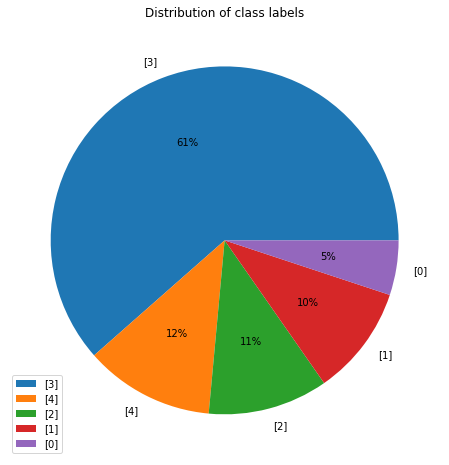

In [ ]:
plt.figure(figsize=(20, 8))

plt.pie(
    train.label.value_counts(), 
    labels=['[3]', '[4]', '[2]', '[1]', '[0]'],
    autopct='%d%%'
)
plt.title('Distribution of class labels')
plt.legend()

In [ ]:
import json

with open(basepath+"/label_num_to_disease_map.json") as f:
    class_mapping = json.load(f)

class_mapping2 ={int(k):v for k,v in class_mapping.items()}

class_mapping2

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [ ]:
image_list = train['image_id'].to_list()
label_list = train['label'].to_list()

Model Training and Augementation. 

In [ ]:
BATCH_SIZE =8 #Mini-Batch Gradient Descent
STEPS_PER_EPOCH = len(train)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train)*0.2 / BATCH_SIZE
EPOCHS = 2 #Set to 20
TARGET_SIZE = 350

In [ ]:
train.label = train.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     rotation_range = 45,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1,
                                     featurewise_center = True,
                                     featurewise_std_normalization = True)

train_generator = train_datagen.flow_from_dataframe(train,
                         directory = os.path.join(train_images_path),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse",
                         shuffle= True)


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train,
                         directory = os.path.join(train_images_path),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
def create_model():
    conv_base = Xception(include_top=False, weights="imagenet", input_tensor=None,
    pooling=None, input_shape=(TARGET_SIZE, TARGET_SIZE, 3), classifier_activation='softmax')
                               
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()

In [ ]:
# model_save = ModelCheckpoint('./Xception_model2.h5', 
#                              save_best_only = True, 
#                              save_weights_only = True,
#                              monitor = 'val_loss', 
#                              mode = 'min', verbose = 1)
# early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
#                            patience = 5, mode = 'min', verbose = 1,
#                            restore_best_weights = True)
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
#                               patience = 2, min_delta = 0.001, 
#                               mode = 'min', verbose = 1) #reduced learning rate


# history = model.fit(
#     train_generator,
#     steps_per_epoch = STEPS_PER_EPOCH,
#     epochs = EPOCHS,
#     validation_data = validation_generator,
#     validation_steps = VALIDATION_STEPS,
#     callbacks = [model_save, early_stop, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
2139/2139 [==============================] - 938s 438ms/step - loss: 0.5650 - acc: 0.8029 - val_loss: 0.7073 - val_acc: 0.7756

Epoch 00001: val_loss improved from inf to 0.70733, saving model to ./Xception_best_weights2.h5
Epoch 2/2
2139/2139 [==============================] - 936s 438ms/step - loss: 0.5266 - acc: 0.8161 - val_loss: 0.5331 - val_acc: 0.8273

Epoch 00002: val_loss improved from 0.70733 to 0.53314, saving model to ./Xception_best_weights2.h5


In [ ]:
# model.save('./Xception_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Load the trained model and use it for predictions

In [ ]:
model = keras.models.load_model('Xception_model.h5')

In [ ]:
test_image = Image.open(basepath+'/test_images/2216849948.jpg')
# test_image

In [ ]:
predict_cassava = []
test_image = test_image.resize((TARGET_SIZE, TARGET_SIZE))
test_image = np.expand_dims(test_image, axis = 0)
predict_cassava.append(np.argmax(model.predict(test_image)))
predict_cassava

[4]

In [ ]:
for img_file in os.listdir('/content/test_images/'):
    if '.jpg' in img_file:
      print('/content/test_images/'+img_file)
      test_image = Image.open('/content/test_images/'+img_file)
      predict_cassava = []
      test_image = test_image.resize((TARGET_SIZE, TARGET_SIZE))
      test_image = np.expand_dims(test_image, axis = 0)
      predict_cassava.append(np.argmax(model.predict(test_image)))
      predict_cassava

/content/test_images/6442965.jpg
/content/test_images/2216849948.jpg
/content/test_images/2321458.jpg
/content/test_images/1726153.jpg
